In [1]:

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import numpy as np
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers

2023-04-28 13:02:22.878799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 13:02:22.917340: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-28 13:02:23.655951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14799172751197446469
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14455472128
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7542846844870929705
physical_device_desc: "device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2023-04-28 13:02:23.668461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-28 13:02:23.669007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-28 13:02:23.669780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 13:02:23.672403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node,

In [2]:

dataset_name = "oxford_flowers102"
dataset_repetitions = 5#5
num_epochs = 20  # train for at least 50 epochs for good results
image_size = 64

# KID = Kernel Inception Distance, see related section

kid_image_size = 75
kid_diffusion_steps = 5
plot_diffusion_steps = 20

# sampling

min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture

embedding_dims = 32 # 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
#widths = [48, 96, 192, 384]
block_depth = 2

# optimization

batch_size = 64
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

In [3]:
def preprocess_image(data):
    # center crop image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    return tf.clip_by_value(image / 255.0, 0.0, 1.0)


def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(dataset_repetitions)
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


# load dataset
train_dataset = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")
val_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")

2023-04-28 13:02:24.243844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-28 13:02:24.244414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-28 13:02:24.244875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-28 13:02:24.245494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-28 13:02:24.246001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [4]:

class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_images = tf.image.grayscale_to_rgb(real_images)
        generated_images = tf.image.grayscale_to_rgb(generated_images)
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()


In [5]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings


def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")

In [6]:
def get_unet(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    #noise_variances = keras.Input(shape=(1, 1, 1))

    #e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    #e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    #x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width_foo in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images], x, name="residual_unet")

In [7]:
#coding=utf-8
import tensorflow as tf 
from keras.models import *
from keras.layers import *

def conv_block(input, filters):
    out = Conv2D(filters, kernel_size=(3,3), strides=1, padding='same')(input)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Conv2D(filters, kernel_size=(3,3), strides=1, padding='same')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    return out

def up_conv(input, filters):
    out = UpSampling2D()(input)
    out = Conv2D(filters, kernel_size=(3,3), strides=1, padding='same')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    return out

def Attention_block(input1, input2, filters):
    g1 = Conv2D(filters, kernel_size=1, strides=1, padding='same')(input1)
    g1 = BatchNormalization()(g1)
    x1 = Conv2D(filters, kernel_size=1, strides=1, padding='same')(input2)
    x1 = BatchNormalization()(x1)
    psi = Activation('relu')(add([g1, x1]))
    psi = Conv2D(filters, kernel_size=1, strides=1, padding='same')(psi)
    psi = BatchNormalization()(psi)
    psi = Activation('sigmoid')(psi)
    out = multiply([input2, psi])
    return out
    

def getAttUNet(image_size, widths, block_depth):

    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])
    
    n1 = 32
    filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

    e1 = conv_block(x, filters[0])

    e2 = MaxPooling2D(strides=2)(e1)
    e2 = conv_block(e2, filters[1])

    e3 = MaxPooling2D(strides=2)(e2)
    e3 = conv_block(e3, filters[2])

    e4 = MaxPooling2D(strides=2)(e3)
    e4 = conv_block(e4, filters[3])

    e5 = MaxPooling2D(strides=2)(e4)
    e5 = conv_block(e5, filters[4])

    d5 = up_conv(e5, filters[3])
    x4 =  Attention_block(d5, e4, filters[3])
    d5 = Concatenate()([x4, d5])
    d5 = conv_block(d5, filters[3])

    d4 = up_conv(d5, filters[2])
    x3 =  Attention_block(d4, e3, filters[2])
    d4 = Concatenate()([x3, d4])
    d4 = conv_block(d4, filters[2])

    d3 = up_conv(d4, filters[1])
    x2 =  Attention_block(d3, e2, filters[1])
    d3 = Concatenate()([x2, d3])
    d3 = conv_block(d3, filters[1])

    d2 = up_conv(d3, filters[0])
    x1 =  Attention_block(d2, e1, filters[0])
    d2 = Concatenate()([x1, d2])
    d2 = conv_block(d2, filters[0])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(d2)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet" )

In [8]:
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = getAttUNet(image_size, widths, block_depth)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        #self.kid = KID(name="kid")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 3))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=kid_diffusion_steps
        )
        #self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
        # plot random generated images for visual evaluation of generation quality
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()
    # ===QUI INIZIANO LE MIE MODIFICHE===

    def custom_denormalize(self, images): # Ritorna anche la versione unclipped
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0), images

    def reverse_diffusion_step(self, step, num_images, step_size, next_noisy_images):
        # print('Reverse Next Noisy images:', tf.math.reduce_sum(next_noisy_images))
        noisy_images = next_noisy_images

        # separate the current noisy image to its components
        diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # print('Reverse noise and signal rates #1:', tf.math.reduce_sum(noise_rates), tf.math.reduce_sum(signal_rates))
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )
        # print('Reverse Pred images', step, tf.math.reduce_sum(pred_images))
        
        # print('Reverse signal rates:', tf.math.reduce_sum(signal_rates))
        # print('Reverse noise rates:', tf.math.reduce_sum(noise_rates))
        # print('Reverse pred noises:', tf.math.reduce_sum(pred_noises))
        # network used in eval mode

        # remix the predicted components using the next signal and noise rates
        next_diffusion_times = diffusion_times - step_size
        next_noise_rates, next_signal_rates = self.diffusion_schedule(
            next_diffusion_times
        )
        # print('Reverse noise and signal rates #2:', tf.math.reduce_sum(next_noise_rates), tf.math.reduce_sum(next_signal_rates))
        next_noisy_images = (
            next_signal_rates * pred_images + next_noise_rates * pred_noises
        )
        # print('Reverse Next noisy images:', tf.math.reduce_sum(next_noisy_images))
        return next_noisy_images, pred_images, pred_noises
        # this new noisy image will be used in the next step

    def custom_reverse_diffusion(self, initial_noise, diffusion_steps): # Uguale a reverse_diffusion, ma salva i noise intermedi
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps
        noise_list = []

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            next_noisy_images, pred_images, pred_noises = self.reverse_diffusion_step(step, num_images, step_size, next_noisy_images)
            noise_list.append(pred_noises)
            # print('Reverse Noise', step, tf.math.reduce_sum(pred_noises))

        return pred_images, noise_list

    def custom_generate(self, diffusion_steps, initial_noise):
        # noise -> images -> denormalized images
        generated_images, noise_list = self.custom_reverse_diffusion(initial_noise, diffusion_steps)
        # print('Pre-denormalization sum:', tf.math.reduce_sum(generated_images))
        generated_images, unclipped = self.custom_denormalize(generated_images)
        return generated_images, unclipped, noise_list

    def normalize(self, images):
        return (images - self.normalizer.mean) / (self.normalizer.variance**0.5)

    def forward_diffusion_step(self, step, num_images, step_size, next_noisy_images, pred_noises, last_step):
        diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size

        # print('Forward Next Noisy images:', tf.math.reduce_sum(next_noisy_images))
        if last_step:
            # L'ultimo step nel reverse il modello non ritorna next_noisy_images (come tutte le altre volte), ma ritorna
            # pred_images. Possiamo quindi usarlo direttamente
            pred_images = next_noisy_images
        else:
            # Primo step: ricostruisci pred_images e pred_noises da next_noisy_images
            # Visto che non è iniettiva, ci siamo salvati al forward pass pred_noises
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            #print('Forward noise and signal rates #1:', tf.math.reduce_sum(next_noise_rates), tf.math.reduce_sum(next_signal_rates))
            # Originale: next_noisy_images = next_signal_rates * pred_images + next_noise_rates * pred_noises
            pred_images = (next_noisy_images - next_noise_rates * pred_noises) / next_signal_rates
        
        # print('Pred images', step, tf.math.reduce_sum(pred_images))

        # Secondo step: componi pred_noises e pred_images in noisy_images
        # (stiamo essenzialmente ricostruendo l'immagine originale che era stata scomposta in image e noise)
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        #print('Forward noise and signal rates #2:', tf.math.reduce_sum(noise_rates), tf.math.reduce_sum(signal_rates))
        # Originale: pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        noisy_images = pred_images * signal_rates + noise_rates * pred_noises
        # print('Forward Noisy images:', tf.math.reduce_sum(noisy_images))
        # print('Forward signal rates:', tf.math.reduce_sum(signal_rates))
        # print('Forward noise rates:', tf.math.reduce_sum(noise_rates))
        # print('Forward pred noises:', tf.math.reduce_sum(pred_noises))

        return noisy_images

    def forward_diffusion(self, pred_images, diffusion_steps, noise_list):
        num_images = pred_images.shape[0]
        step_size = 1.0 / diffusion_steps

        next_noisy_images = pred_images
        steps = list(reversed(range(diffusion_steps))) # Doing it in the opposite order
        noise_list = list((noise_list))
        for step in steps:
            # print('Forward Noise', step, tf.math.reduce_sum(list(reversed(noise_list))[step]))
            last_step = step == list(range(diffusion_steps))[-1]
            if last_step:
                pass #print('Last!')
            next_noisy_images = self.forward_diffusion_step(step, num_images, step_size, next_noisy_images, noise_list[step], last_step)

        return next_noisy_images

    def reverse_generate(self, generated_images, diffusion_steps, noise_list):
        generated_images = self.normalize(generated_images)
        # print('Post-normalization sum:', tf.math.reduce_sum(generated_images))
        return self.forward_diffusion(generated_images, diffusion_steps, noise_list)
    
    def forward_and_backward(self, num_images, diffusion_steps):
        tf.random.set_seed(0)
        print(num_images)
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 3))
        generated_images, unclipped, noise_list = self.custom_generate(
            diffusion_steps=diffusion_steps,
            initial_noise=initial_noise
        )
        print('Noise:', len(noise_list), noise_list[0].shape)
        reconstructed_noise = self.reverse_generate(unclipped, diffusion_steps, noise_list)

        print('Mean abs distance:', tf.math.reduce_mean(tf.abs(reconstructed_noise - initial_noise)))


        plt.figure(figsize=(3 * 2.0, num_images * 2.0))
        for row in range(num_images):
            base_index = row * 3 + 1
            plt.subplot(num_images, 3, base_index)
            plt.imshow(initial_noise[row])
            plt.axis("off")

            plt.subplot(num_images, 3, base_index + 1)
            plt.imshow(generated_images[row])
            plt.axis("off")

            plt.subplot(num_images, 3, base_index + 2)
            plt.imshow(reconstructed_noise[row])
            plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()

In [9]:
!pip install tensorflow_addons

In [10]:

model = DiffusionModel(image_size, widths, block_depth)

checkpoint_path = "./hello/"
# below tensorflow 2.9:
#!pip install tensorflow_addons
import tensorflow_addons as tfa
optimizer=tfa.optimizers.AdamW
model.compile(
    optimizer=optimizer(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
# pixelwise mean absolute error is used as loss

# save the best model based on thmodel.load_weights(checkpoint_path)e validation KID metric
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    #monitor="val_kid",
    mode="min",
    save_best_only=True,
)

# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)
#model.set_weights(test)

Epoch 1/30


2023-04-28 13:02:30.458849: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-28 13:02:30.528661: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-04-28 13:02:31.114734: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-28 13:02:31.115091: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-28 13:02:31.115105: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-04-28 13:02:31.115430: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-28 13:02:31.115474: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to

511/511 [==============================] - ETA: 0s - n_loss: 0.2561

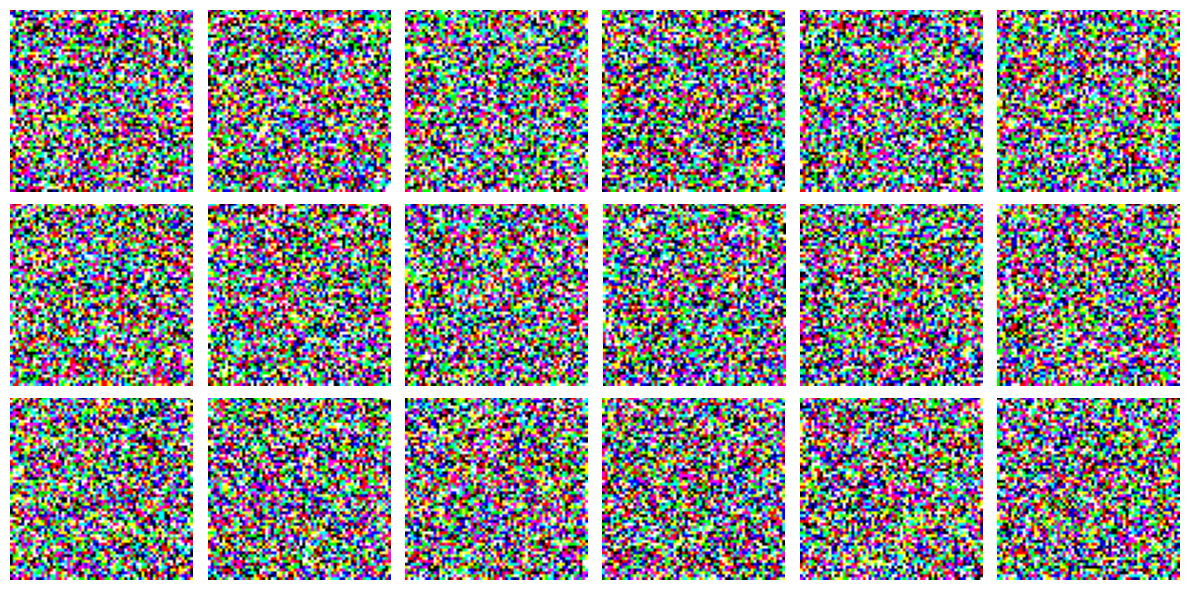

511/511 [==============================] - 57s 98ms/step - n_loss: 0.2561 - val_n_loss: 0.7958 - val_i_loss: 2.4663
Epoch 2/30
511/511 [==============================] - ETA: 0s - n_loss: 0.1728

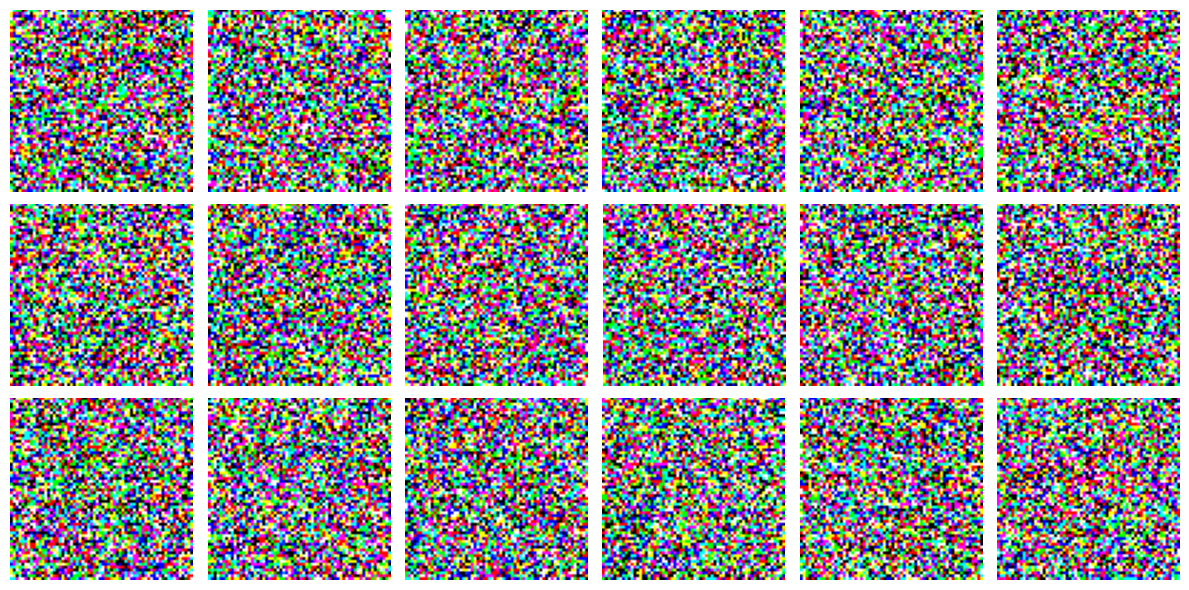

511/511 [==============================] - 48s 95ms/step - n_loss: 0.1728 - val_n_loss: 0.7633 - val_i_loss: 2.3157
Epoch 3/30
511/511 [==============================] - ETA: 0s - n_loss: 0.1672

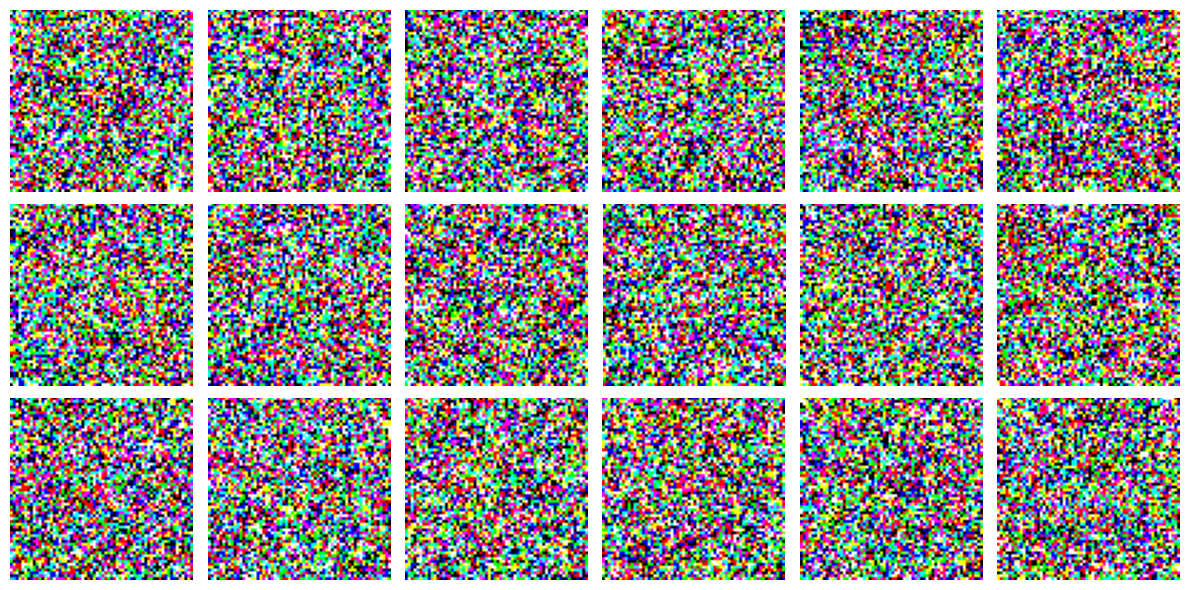

511/511 [==============================] - 49s 96ms/step - n_loss: 0.1672 - val_n_loss: 0.6856 - val_i_loss: 2.0663
Epoch 4/30
323/511 [=================>............] - ETA: 16s - n_loss: 0.1636

In [ ]:

# run training and plot generated images periodically
model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        #checkpoint_callback,
    ],
)


In [10]:
weights_list = model.get_weights()

In [11]:
np.save("./weights_flowers_big",np.array(weights_list,dtype=object))

In [10]:
test = np.load("/home/fmerizzi/Documents/Diffusion_models/weights_flowers.npy",allow_pickle=True)

In [11]:
model.set_weights(test)

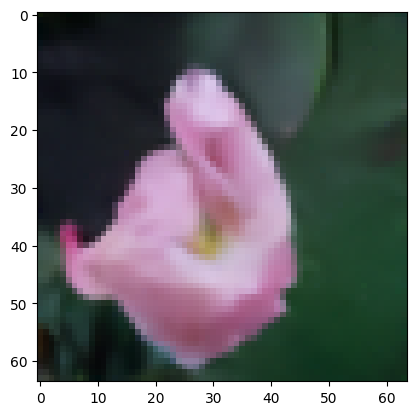

In [14]:
image2 = model.generate(
            num_images=1,
            diffusion_steps=plot_diffusion_steps,
)
plt.imshow(image2[0])
plt.show()

In [ ]:

# %%
# Per semplicità ho messo il noise da identificare come parametro di un modello

class StartingPointInitializer(keras.initializers.Initializer):
    def __init__(self, starting_point, mean, stddev):
        self.starting_point = starting_point
        self.mean = mean
        self.stddev = stddev

    def __call__(self, shape, dtype=None):
        return self.starting_point + tf.random.normal(
            shape, mean=self.mean, stddev=self.stddev, dtype=dtype)

    def get_config(self):  # To support serialization
        return {'mean': self.mean, 'stddev': self.stddev, 'starting_point' : self.starting_point}



class DescentModel(keras.Model):
    def __init__(self, reference_model, n, custom_initializer=None):
        super().__init__()
        self.reference_model = reference_model
        self.n = n
        self.custom_initializer = custom_initializer
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, widths, block_depth)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings


def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

def get_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 1))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width_foo in reversed(widths[:-1]): # TODO: QUESTO VA CORRETTO IN PROD!
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(1, kernel_size=1, kernel_initializer="zeros")(x)
")
        #self.kid = KID(name="kid")
    
    def load_weights(self, filename):
        self.network.load_weights(filename)
        self.ema_network.load_weights(filename)

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker]
    #, self.kid]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 1))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 1))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 1))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        #images = self.denormalize(images)
        #generated_images = self.generate(
        #    num_images=batch_size, diffusion_steps=kid_diffusion_steps
        #)
        #self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
        # plot random generated images for visual evaluation of generation quality
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(tf.reshape(generated_images[index],[32,32,3]))
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()

    def build(self, input_shape):
        # Per semplicità uso uniform, ma probabilmente si potrebbe accelerare facendo sampling gaussiano

        print('Input shape:', input_shape)
        if self.custom_initializer is None:
            initializer = 'random_normal'
        else:
            initializer = self.custom_initializer

        self._initial_noise = self.add_weight(name='initial_noise', shape=(self.n,) + input_shape[1:], initializer=initializer, trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        print(self._initial_noise.shape)
        generated_images = self.reference_model.reverse_diffusion(self._initial_noise, diffusion_steps=20)
        # generated_images = self.reference_model.denormalize(generated_images)
        generated_images = self.reference_model.normalizer.mean + generated_images * self.reference_model.normalizer.variance**0.5
        return generated_images
    
    def compute_output_shape(self, input_shape):
        return (self.n,) + input_shape[1:]

def loss_function(ground_truth, predicted):
    # Se si usa MSE si ottiene una loss troppo alta e finisce in nan/infinity
    return tf.reduce_sum(tf.math.abs(ground_truth - predicted))

def diffusion_descent(ground_truth, n):
    ground_truth = tf.expand_dims(ground_truth, 0)
    #for std, color in [(0, 'red'), (0.001, 'blue'), (0.01, 'green'), (0.1, 'violet'), (1, 'black')]:
    descent_model = DescentModel(model, n, custom_initializer=StartingPointInitializer(ground_truth, 0,1))
    descent_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-2),
        loss=loss_function
    )
    history = descent_model.fit(
        x=ground_truth,
        y=ground_truth,
        epochs=200
    )

    #plt.plot(history.history['loss'], color=color)
    
    plt.legend([0, 0.001, 0.01, 0.1, 1])
    plt.show()

    output = descent_model.predict(
        ground_truth
    )
    # plt.figure()
    # plt.subplot(1, 2, 1)
    # plt.imshow(ground_truth[0])
    # plt.subplot(1, 2, 2)
    # plt.imshow(output[0])
    # plt.show()
    return output, descent_model._initial_noise


# Same Seed Two Models

In [16]:
np.save("./flowers_sample_noises_grav",np.array(noises))
np.save("./flowers_sample_gens_grav",np.array(gens))

In [ ]:
np.save("./flowers_sample_gens2_grav",np.array(gens2))

In [14]:
noises = np.load("./flowers_sample_noises_grav.npy")
gens = np.load("./flowers_sample_gens_grav.npy")

In [15]:
noises = []
gens = []

for i in range(6):
    noise_sample = tf.random.normal(shape=(1, 64, 64, 3))
    generated_images = model.reverse_diffusion(noise_sample, 20)
    generated_images = model.denormalize(generated_images)
    noises.append(noise_sample)
    gens.append(generated_images[0])

In [15]:
gens3 = []

for i in range(6):
    generated_images = model.reverse_diffusion(noises[i], 20)
    generated_images = model.denormalize(generated_images)
    gens3.append(generated_images[0])

<Figure size 640x480 with 0 Axes>

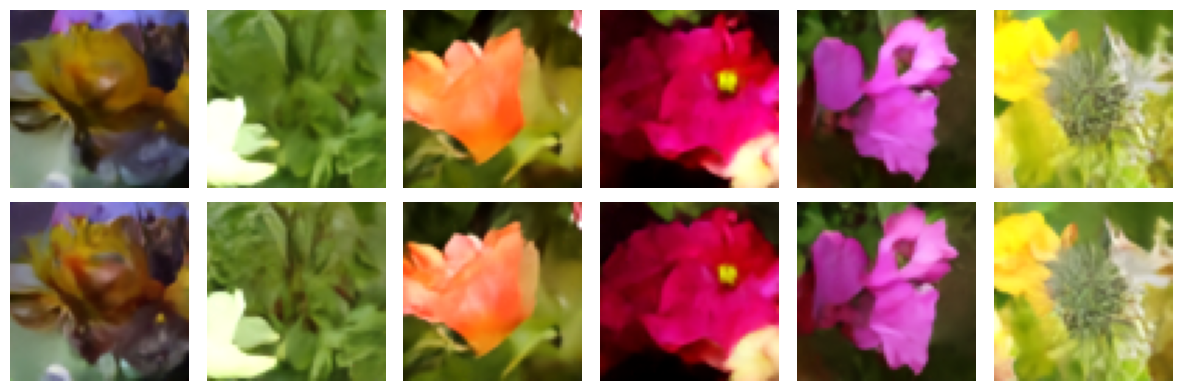

In [16]:
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,6,figsize=(15, 5)) 
f.subplots_adjust(hspace=0,wspace=0.1)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
for i in range(6):
    axarr[0,i].imshow(gens[i])
    axarr[1,i].imshow(gens3[i])
    axarr[0,i].axis('off')
    axarr[1,i].axis('off')




In [ ]:
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(4,5,figsize=(12, 10)) 
f.subplots_adjust(hspace=0,wspace=0.1)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
for i in range(5):
    axarr[0,i].imshow(noises[i][0])
    axarr[1,i].imshow(gens[i])
    axarr[2,i].imshow(gens2[i])
    axarr[3,i].imshow(gens3[i])
    axarr[0,i].axis('off')
    axarr[1,i].axis('off')
    axarr[2,i].axis('off')
    axarr[3,i].axis('off')

# Inversion Model

In [12]:
input_shape = (64, 64, 3)

In [13]:
inv_model1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(3, strides=1, kernel_size=(5, 5),activation=None,padding="same")
    ]
)

In [13]:
inv_model2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16,(5, 5),strides=1,padding="same", activation="relu"),
        layers.Conv2D(16,(5, 5),strides=1, padding="same", activation="relu"),
        layers.Conv2D(3,(5, 5),strides=1,padding="same",activation=None)
    ]
)

In [19]:
inv_model3 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64,(5, 5),strides=1,padding="same", activation="relu"),
        layers.Conv2D(64,(5, 5),strides=1, padding="same", activation="relu"),
        layers.Conv2D(3,(5, 5),strides=1,padding="same",activation=None)
    ]
)

In [13]:
inv_model4 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(128,(5, 5),strides=1,padding="same", activation="relu"),
        layers.Conv2D(128,(5, 5),strides=1, padding="same", activation="relu"),
        layers.Conv2D(128,(3, 3),strides=1,padding="same", activation="relu"),
        layers.Conv2D(128,(3, 3),strides=1, padding="same", activation="relu"),
        layers.Conv2D(128,(3, 3),strides=1, padding="same", activation="relu"),
        layers.Conv2D(3,(5, 5),strides=1,padding="same",activation=None)
    ]
)

In [25]:
inv_model5 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(32, (5, 5), activation='relu',padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(3, (5, 5), activation=None, padding='same')
    ]
)

In [15]:
unet = get_unet(image_size, widths, block_depth)

In [21]:
hello = list(train_dataset)

In [22]:
hellonp = np.array(hello)

In [23]:
hellonp.shape

(1023, 32, 64, 64, 3)

In [24]:
test = np.reshape(hellonp, (32736, 64, 64, 3))

In [18]:
red_test = test[0:1920]

In [25]:
test.shape

(32736, 64, 64, 3)

In [19]:
unet.compile(optimizer=optimizer,loss=visible_loss)
unet.load_weights("./flowers_unet_fin2")

In [26]:
#inv_model.load_weights(weights_name)
  
def visible_loss(y_true,y_pred):
   #y_pred is the seed
   print(y_pred.shape)
   generated = model.reverse_diffusion(y_pred, 10)
   generated = model.denormalize(generated)
   err = tf.reduce_mean(tf.math.abs(y_true - generated))
   return err

optimizer=keras.optimizers.Adam(learning_rate=.0001)
unet.fit(test,test,epochs=6,batch_size=32)
unet.save_weights("flowers_unet_fin2")

2022-12-21 21:42:15.515281: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1609039872 exceeds 10% of free system memory.
2022-12-21 21:42:15.943294: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1609039872 exceeds 10% of free system memory.
2022-12-21 21:42:16.381965: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1609039872 exceeds 10% of free system memory.
2022-12-21 21:42:16.702787: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1609039872 exceeds 10% of free system memory.


Epoch 1/6
(32, 64, 64, 3)
(32, 64, 64, 3)
1023/1023 [==============================] - 594s 559ms/step - loss: 0.0447
Epoch 2/6
1023/1023 [==============================] - 569s 557ms/step - loss: 0.0427
Epoch 3/6
1023/1023 [==============================] - 569s 556ms/step - loss: 0.0411
Epoch 4/6
1023/1023 [==============================] - 574s 561ms/step - loss: 0.0396
Epoch 5/6
1023/1023 [==============================] - 569s 557ms/step - loss: 0.0382
Epoch 6/6
1023/1023 [==============================] - 572s 559ms/step - loss: 0.0371


In [27]:
unet.save_weights("flowers_unet_fin2")

In [22]:
unet.load_weights("flowers_unet_fin2")

In [ ]:
#inv_model.save_weights("inv_model_final")

In [ ]:
 inv_model2.save_weights("inv_model2_final")

In [ ]:
inv_model3.load_weights("inv_model3_final")

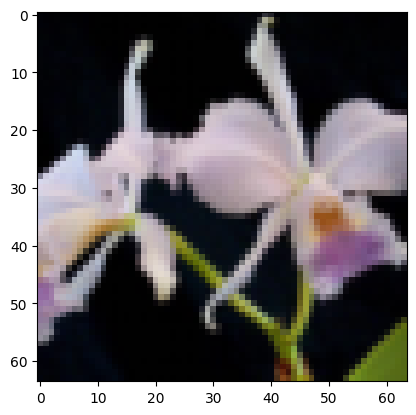

In [28]:
plt.imshow(np.reshape(test[2204],[64,64,3]))
plt.show()

In [29]:
predicted = unet.predict(np.reshape(test[2204],[1,64,64,3]))

1/1 [==============================] - 1s 540ms/step


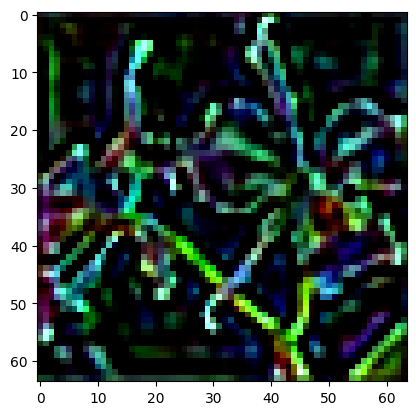

In [30]:
plt.imshow(np.reshape(predicted,[64,64,3]))
plt.show()

In [31]:
generated_images = model.reverse_diffusion(np.reshape(predicted,[1,64,64,3]), 10)
generated_images = model.denormalize(generated_images)

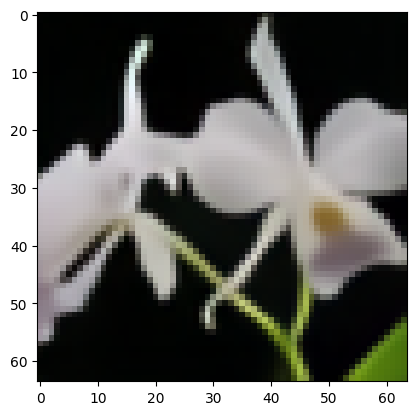

In [32]:
plt.imshow(np.reshape(generated_images,[64,64,3]))
plt.show()

In [33]:
mses=0
samples = 500
for i in range(samples):
    print("--num--> " + str(i))
    predicted = unet.predict(np.reshape(test[2800+i],[1,64,64,3]))
    generated_images = model.reverse_diffusion(np.reshape(predicted,[1,64,64,3]), 10)
    generated_images = model.denormalize(generated_images)
    
    one = np.reshape(generated_images,[64,64,3])
    two = np.reshape(test[2800+i],[64,64,3])
    mse = np.square(np.subtract(two,one)).mean()
    
    mses=mses+mse
print(mses/samples)

--num--> 0
1/1 [==============================] - 0s 20ms/step
--num--> 1
1/1 [==============================] - 0s 15ms/step
--num--> 2
1/1 [==============================] - 0s 19ms/step
--num--> 3
1/1 [==============================] - 0s 18ms/step
--num--> 4
1/1 [==============================] - 0s 17ms/step
--num--> 5
1/1 [==============================] - 0s 19ms/step
--num--> 6
1/1 [==============================] - 0s 20ms/step
--num--> 7
1/1 [==============================] - 0s 21ms/step
--num--> 8
1/1 [==============================] - 0s 24ms/step
--num--> 9
1/1 [==============================] - 0s 19ms/step
--num--> 10
1/1 [==============================] - 0s 22ms/step
--num--> 11
1/1 [==============================] - 0s 18ms/step
--num--> 12
1/1 [==============================] - 0s 20ms/step
--num--> 13
1/1 [==============================] - 0s 23ms/step
--num--> 14
1/1 [==============================] - 0s 21ms/step
--num--> 15
1/1 [==============================] -

1/1 [==============================] - 0s 18ms/step
--num--> 254
1/1 [==============================] - 0s 18ms/step
--num--> 255
1/1 [==============================] - 0s 18ms/step
--num--> 256
1/1 [==============================] - 0s 19ms/step
--num--> 257
1/1 [==============================] - 0s 20ms/step
--num--> 258
1/1 [==============================] - 0s 19ms/step
--num--> 259
1/1 [==============================] - 0s 19ms/step
--num--> 260
1/1 [==============================] - 0s 19ms/step
--num--> 261
1/1 [==============================] - 0s 18ms/step
--num--> 262
1/1 [==============================] - 0s 19ms/step
--num--> 263
1/1 [==============================] - 0s 18ms/step
--num--> 264
1/1 [==============================] - 0s 19ms/step
--num--> 265
1/1 [==============================] - 0s 21ms/step
--num--> 266
1/1 [==============================] - 0s 20ms/step
--num--> 267
1/1 [==============================] - 0s 19ms/step
--num--> 268
1/1 [====================

In [30]:
mses=0
samples = 50
for i in range(samples):
    predicted = inv_model1.predict(np.reshape(test[2800+i],[1,64,64,3]))
    generated_images = model.reverse_diffusion(np.reshape(predicted,[1,64,64,3]), 10)
    generated_images = model.denormalize(generated_images)
    
    one = np.reshape(generated_images,[64,64,3])
    two = np.reshape(test[2800+i],[64,64,3])
    mse = np.square(np.subtract(two,one)).mean()
    
    mses=mses+mse
print(mses/samples)

1/1 [==============================] - 0s 16ms/step
0.037287498135119675


In [ ]:
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(3,5,figsize=(8, 5)) 
f.subplots_adjust(hspace=0.4,wspace=0)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
for i in range(5):
    axarr[0,i].imshow(np.reshape(test[2200+i],[32,32,1]))
    axarr[0,i].axis('off')
    axarr[1,i].axis('off')
    axarr[2,i].axis('off')


for i in range(5):
    predicted = inv_model2.predict(np.reshape(test[2200+i],[1,32,32,1]))
    axarr[1,i].imshow(np.reshape(predicted,[32,32,1]))
    generated_images = model.reverse_diffusion(np.reshape(predicted,[1,32,32,1]), 10)
    generated_images = model.denormalize(generated_images)
    axarr[2,i].imshow(np.reshape(generated_images,[32,32,1]))
    
    one = np.reshape(generated_images,[32,32])
    two = np.reshape(test[2200+i],[32,32])
    mse = np.square(np.subtract(two,one)).mean()
    
    axarr[2,i].set_title("mse:"+ str(np.round(mse,4)))
    


In [ ]:
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(3,5,figsize=(8, 5)) 
f.subplots_adjust(hspace=0.4,wspace=0)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
for i in range(5):
    axarr[0,i].imshow(np.reshape(test[2200+i],[32,32,1]))
    axarr[0,i].axis('off')
    axarr[1,i].axis('off')
    axarr[2,i].axis('off')


for i in range(5):
    predicted = inv_model3.predict(np.reshape(test[2200+i],[1,32,32,1]))
    axarr[1,i].imshow(np.reshape(predicted,[32,32,1]))
    generated_images = model.reverse_diffusion(np.reshape(predicted,[1,32,32,1]), 10)
    generated_images = model.denormalize(generated_images)
    axarr[2,i].imshow(np.reshape(generated_images,[32,32,1]))
    
    one = np.reshape(generated_images,[32,32])
    two = np.reshape(test[2200+i],[32,32])
    mse = np.square(np.subtract(two,one)).mean()
    
    axarr[2,i].set_title("mse:"+ str(np.round(mse,4)))
    


In [ ]:
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(3,5,figsize=(8, 5)) 
f.subplots_adjust(hspace=0.4,wspace=0)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
for i in range(5):
    axarr[0,i].imshow(np.reshape(test[2200+i],[32,32,1]))
    axarr[0,i].axis('off')
    axarr[1,i].axis('off')
    axarr[2,i].axis('off')


for i in range(5):
    axarr[1,i].imshow(np.reshape(test[2200+i],[32,32,1]))
    generated_images = model.reverse_diffusion(np.reshape(test[2200+i],[1,32,32,1]), 10)
    generated_images = model.denormalize(generated_images)
    axarr[2,i].imshow(np.reshape(generated_images,[32,32,1]))
    
    one = np.reshape(generated_images,[32,32])
    two = np.reshape(test[2200+i],[32,32])
    mse = np.square(np.subtract(two,one)).mean()
    
    axarr[2,i].set_title("mse:"+ str(np.round(mse,4)))

In [ ]:
outputs = np.load("/home/fmerizzi/Documents/ouputs.npy")
initial_noises = np.load("/home/fmerizzi/Documents/initial_noises.npy")

In [ ]:
for i in range(1,20,1):
    outputs = np.append(outputs,np.load("/home/fmerizzi/Documents/ouputs"+str(i)+".npy"),axis=0)
    initial_noises = np.append(initial_noises,np.load("/home/fmerizzi/Documents/initial_noises"+str(i)+".npy"),axis=0)

In [ ]:
all_seeds = initial_noises

In [ ]:
from sklearn.decomposition import PCA
mean_seed = np.mean(all_seeds, axis=0).squeeze()
all_seeds = all_seeds.reshape([all_seeds.shape[0], -1])


In [ ]:
all_seeds.shape

In [ ]:
from sklearn.decomposition import PCA
mean_seed = np.mean(all_seeds, axis=0).squeeze()
all_seeds = all_seeds.reshape([all_seeds.shape[0], -1])
pca = PCA(1024).fit(all_seeds)
u = pca.components_

print(mean_seed.shape)

In [ ]:
mean_seed = np.reshape(mean_seed,[32,32])

In [ ]:

for index in [1, 2, 3]:
    target_eigenvector = u[-index]

    new_seeds = []

    coefficients = [-3, -1.5, -1, -.5, 0, .5, 1, 1.5, 3]

    for coeff in coefficients:
        normalized_target_eigenvector = target_eigenvector
        new_seed = mean_seed + coeff * normalized_target_eigenvector.reshape((32, 32))
        new_seeds.append(new_seed)

    new_seeds = np.array(new_seeds)
    new_seeds = new_seeds.reshape(new_seeds.shape[0], 32, 32, 1)
    generated_images = model.reverse_diffusion(new_seeds, 10)
    generated_images = model.denormalize(generated_images)
    new_outputs=generated_images
    print(new_outputs.shape)

    def plot_images(images, path, titles=None, columns=2):
        from math import ceil
        columns = min(columns, len(images))
        rows = int(ceil(len(images) / columns))

        if columns == 1 and rows == 1:
            plt.imshow(images[0])
            if titles is not None:
                plt.title(titles[0])
            plt.axis('off')
        else:
            _, axs = plt.subplots(rows, columns, figsize=(4 * columns, 4 * rows))
            plt.tight_layout()
            axs = axs.flatten()

            for i in range(len(images)):
                axs[i].imshow(images[i], cmap='gray')
                if titles is not None:
                    axs[i].set_title(titles[i])
            for axis in axs:
                axis.axis('off')
        plt.show()

    plt.title(f'Component -{index}')
    plt.tight_layout()
    np.random.seed(0)
    plot_images(new_outputs, f'eigen_{index}.png', titles=[f'coeff = {coeff}' for coeff in coefficients], columns=3)